##Satellite data to sensor data modeling

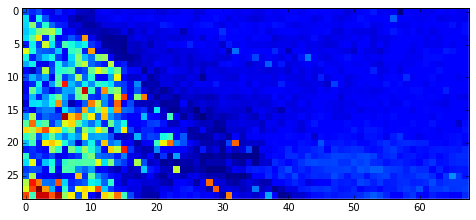

,315nm POM-01 Photometer [nA],400nm POM-01 Photometer [uA],500nm POM-01 Photometer [uA],675nm POM-01 Photometer [uA],870nm POM-01 Photometer [uA],940nm POM-01 Photometer [uA],1020nm POM-01 Photometer [uA],315nm Obsolete AOD,400nm Obsolete AOD,500nm Obsolete AOD,675nm Obsolete AOD,870nm Obsolete AOD,940nm Obsolete AOD,1020nm Obsolete AOD
datetime,,,,,,,,,,,,,,
2014-04-08 18:00:00,-2194.917883,-2179.650583,-2065.379667,-2005.4225,-2060.177167,-2117.088833,-2093.865833,-2216.45358,-2216.194319,-2216.29417,-2216.333306,-2216.345249,-2216.202907,-2216.346496


In [2]:
from datetime import datetime,timedelta, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from data_helper_functions import *
from IPython.display import display
pd.options.display.max_columns = 999
%matplotlib inline

desired_channel = 'BAND_01'
desired_date = datetime(2014, 4, 8)
desired_timedelta = timedelta(hours = 18)
desired_datetime = desired_date + desired_timedelta
satellite_filefolder = 'data/satellite/colorado/summer6months/data/'
sensor_filefolder = 'data/sensor_data/colorado6months/'
pvoutput_filefolder = 'data/pvoutput/pvoutput6months/'

#satellite data
satellite_filename = find_filename(desired_datetime, desired_channel, satellite_filefolder)
lons, lats, data = return_satellite_data(satellite_filename, satellite_filefolder)

plt.figure(figsize=(8, 8))
imgplot = plt.imshow(data)
imgplot.set_interpolation('none')
plt.show()

#sensor data
sensor_filename = find_file_from_date(desired_date, sensor_filefolder)
df_sensor = return_sensor_data(sensor_filename, sensor_filefolder).ix[:,-15:-1]
df_sensor[df_sensor.index == desired_datetime]
display(df_sensor[df_sensor.index == desired_datetime])

In [3]:
np.ravel(data).shape

(1972,)

## Build up satellite and sensor data

In [7]:
#iterate over datetimes:
mytime = datetime(2014, 4, 1, 13)
times = make_time(mytime)

# Now that we can call data up over any datetime and we have a list of interested datetimes,
# we can finally construct an X matrix and y vector for regression.

desired_channel = 'BAND_01'
satellite_filefolder = 'data/satellite/colorado/summer6months/data/'
sensor_filefolder = 'data/sensor_data/colorado6months/'

X = []
Y = []

for desired_datetime in times:
    
    try: #ignore data without satellite images, should update to output datetime of occurrance
        desired_date = (desired_datetime - timedelta(hours=6)).date() #make sure correct date
        desired_date = datetime.combine(desired_date, time.min) #get into datetime format

        satellite_filename = find_filename(desired_datetime, desired_channel, satellite_filefolder)
        lons, lats, data = return_satellite_data(satellite_filename, satellite_filefolder)

        sensor_filename = find_file_from_date(desired_date, sensor_filefolder)
        df_sensor = return_sensor_data(sensor_filename, sensor_filefolder).ix[:,-15:-1]
        df_sensor[df_sensor.index == desired_datetime]

#         pvoutput_filename = find_file_from_date(desired_date, pvoutput_filefolder)
#         df_pvoutput = return_pvoutput_data(pvoutput_filename, pvoutput_filefolder)
        
        X.append(np.ravel(data))
        Y.append(df_sensor[df_sensor.index == desired_datetime].values[0])
    except:
        pass

No file with this datetime within 3 hours!
No file with this datetime within 3 hours!
No file with this datetime within 3 hours!
No file with this datetime within 3 hours!
No file with this datetime within 3 hours!
No file with this datetime within 3 hours!
No file with this datetime within 3 hours!
No file with this datetime within 3 hours!
No file with this datetime within 3 hours!
No file with this datetime within 3 hours!
No file with this datetime within 3 hours!
No file with this datetime within 3 hours!
No file with this datetime within 3 hours!
No file with this datetime within 3 hours!
No file with this datetime within 3 hours!
No file with this datetime within 3 hours!
No file with this datetime within 3 hours!
No file with this datetime within 3 hours!
No file with this datetime within 3 hours!
No file with this datetime within 3 hours!
No file with this datetime within 3 hours!
No file with this datetime within 3 hours!
No file with this datetime within 3 hours!
No file wit

In [43]:
X = np.array(X)
Y = np.array(Y)

In [44]:
print X.shape
print Y.shape

(2544, 1972)
(2544, 14)


##Neural Net model

In [123]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import scale, StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.metrics import *
from lasagne import layers
from lasagne.nonlinearities import  softmax, rectify, sigmoid, linear, very_leaky_rectify, tanh
from lasagne.updates import nesterov_momentum, adagrad, momentum
from nolearn.lasagne import NeuralNet

In [19]:
y = Y.astype('float32') #big Y to little y
x = X.astype('float32') #big X to little x
scaler = StandardScaler()
scaled_x = scaler.fit_transform(x)
x_train, x_test, y_train, y_test = train_test_split(scaled_x, y, test_size = 0.2, random_state = 12)

In [25]:
x.shape[1]

1972

In [33]:
scaled_x[3]

array([ 0.43959174,  0.61257768,  0.49549052, ..., -0.60034823,
       -0.58955151, -0.66364586], dtype=float32)

In [32]:
net1 = NeuralNet(
    layers=[  # three layers: one hidden layer
        ('input', layers.InputLayer),
        ('hidden', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    # layer parameters:
    input_shape=(None, x.shape[1]),  # image size
    hidden_num_units=100,  # number of units in hidden layer
    output_nonlinearity=None,  # output layer uses identity function
    output_num_units=14,  # 14 target values

    # optimization method:
    update=nesterov_momentum,
    update_learning_rate=0.01,
    update_momentum=0.09,

    regression=True,  # flag to indicate we're dealing with regression problem
    max_epochs=400,  # we want to train this many epochs
    verbose=1,
    )

net1.fit(scaled_x, y)

# Neural Network with 198714 learnable parameters

## Layer information

  #  name      size
---  ------  ------
  0  input     1972
  1  hidden     100
  2  output      14

  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1           nan           nan          nan  0.15s
      2           nan           nan          nan  0.13s
      3           nan           nan          nan  0.11s
      4           nan           nan          nan  0.12s
      5           nan           nan          nan  0.11s
      6           nan           nan          nan  0.11s
      7           nan           nan          nan  0.11s
      8           nan           nan          nan  0.11s
      9           nan           nan          nan  0.20s
     10           nan           nan          nan  0.19s
     11           nan           nan          nan  0.20s
     12           nan           nan          nan  0.23s
     13           nan           nan         

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x10a4ca810>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x10a4ca790>,
     custom_score=None, hidden_num_units=100, input_shape=(None, 1972),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('hidden', <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=400, more_params={},
     objective=<function objective at 0x10a755b18>,
     objective_loss_function=<function squared_error at 0x109a565f0>,
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog instance at 0x11b8bca28>],
     on_training_finished=[],
     on_training_started=[<nolearn.lasagne.handlers.PrintLayerInfo instance at 0x11822f5a8>],
     output_nonlinearity=None, output_num_units=14, regression=True,
     train_split=<nolearn.lasagne.base.TrainSplit object at 0x10a4ca850>,
     update=<function nest

##Random Forest regressor model
Neural nets not working 1st time, who would've guessed?!

In [55]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(oob_score=True)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 14)

In [56]:
rfr.fit(X_train,Y_train)

/Users/scott/anaconda/lib/python2.7/site-packages/sklearn/ensemble/forest.py:600: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


RandomForestRegressor(bootstrap=True, compute_importances=None,
           criterion='mse', max_depth=None, max_features='auto',
           max_leaf_nodes=None, min_density=None, min_samples_leaf=1,
           min_samples_split=2, n_estimators=10, n_jobs=1, oob_score=True,
           random_state=None, verbose=0)

In [57]:
rfr.score(X_test,Y_test)

0.093442662655024877

In [58]:
rfr.oob_score_

0.0096693512018427973

In [59]:
Y_pred = rfr.predict(X_test)

In [68]:
val = 100
print Y_pred[val]
print Y_test[val]

[-12419.02534473 -12410.80618377 -12356.9444577  -12324.28702746
 -12348.89734169 -12388.01135035 -12365.56977055  -3125.60144835
  -3125.23774066  -3125.30821753  -3125.32930326  -3125.3380243
  -3125.11893927  -3125.31488453]
[-2081.65131667 -2070.204      -1980.47421667 -1936.56133333 -1980.67578333
 -2025.50371667 -2007.35018333 -2099.65122017 -2099.36738433 -2099.46652683
 -2099.49654417 -2099.49947233 -2099.33611333 -2099.49328117]


##Linear regressor model

In [253]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 14)

In [254]:
lr.fit(X_train,Y_train)

LinearRegression(copy_X=True, fit_intercept=True, normalize=False)

In [255]:
lr.score(X_test,Y_test)

-222.64278500759912

In [256]:
Y_pred = rfr.predict(X_test)

In [268]:
from random import randint
val = randint(0,508)
print Y_pred[val]
print Y_test[val]

[ 6906.70653633  6939.73220954  6986.62261443  7021.54779659  7003.03415723
  6966.2242525   6987.41677219 -1133.95232264 -1133.09091217 -1132.96209366
 -1132.87606238 -1132.79554555 -1132.5208635  -1132.78061842]
[-2318.68881667 -2300.75068333 -2191.94566667 -2132.26266667 -2183.365
 -2253.203      -2215.77516667 -2333.060363   -2332.8778115  -2332.9633125
 -2332.9920775  -2333.0003805  -2332.809689   -2333.000124  ]


##Ridge regression model

In [289]:
from sklearn.linear_model import Ridge
ridge = Ridge()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.5, random_state = 14)

In [290]:
ridge.fit(X_train, Y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, solver='auto', tol=0.001)

In [291]:
ridge.score(X_test,Y_test)

-6.1071156477380981

In [292]:
Y_pred = ridge.predict(X_test)

In [293]:
val = randint(0,508)
print Y_pred[val]
print Y_test[val]

[ 8481.07994688  8584.9537603   8616.64852565  8620.0829562   8601.34456773
  8624.14464114  8590.71068227  6209.31671926  6209.29114993  6209.32020132
  6209.34848965  6209.43477771  6209.18190122  6209.52546508]
[-2090.43820833 -2070.93618333 -1966.34966667 -1900.1695     -1945.3535
 -2001.5885     -1981.12433333 -2099.66916983 -2099.54994117 -2099.63143433
 -2099.66807233 -2099.686643   -2099.587258   -2099.677963  ]


suprisingly, this is very fast and works the best due to it's speed!

##Build up data part 2

In [1]:
from datetime import datetime,timedelta, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from data_helper_functions import *
from IPython.display import display
pd.options.display.max_columns = 999
from __future__ import division
%matplotlib inline

#iterate over datetimes:
mytime = datetime(2014, 4, 1, 13)
times = make_time(mytime)

satellite_filefolder = 'data/satellite/colorado/summer6months/data/'
sensor_filefolder = 'data/sensor_data/colorado6months/'

X = []
Y = []

for desired_datetime in times: 
    
    try: #ignore data without satellite images, should update to output datetime of occurrance
        desired_date = (desired_datetime - timedelta(hours=6)).date() #make sure correct date
        desired_date = datetime.combine(desired_date, time.min) #get into datetime format

        desired_channel = 'BAND_01' #problems with an inner for loop (doesn't look good, but works)
        satellite_filename = find_filename(desired_datetime, desired_channel, satellite_filefolder)
        lons, lats, data1 = return_satellite_data(satellite_filename, satellite_filefolder)
        
        desired_channel = 'BAND_02'
        satellite_filename = find_filename(desired_datetime, desired_channel, satellite_filefolder)
        lons, lats, data2 = return_satellite_data(satellite_filename, satellite_filefolder)
        
        desired_channel = 'BAND_03'
        satellite_filename = find_filename(desired_datetime, desired_channel, satellite_filefolder)
        lons, lats, data3 = return_satellite_data(satellite_filename, satellite_filefolder)               

        desired_channel = 'BAND_04'
        satellite_filename = find_filename(desired_datetime, desired_channel, satellite_filefolder)
        lons, lats, data4 = return_satellite_data(satellite_filename, satellite_filefolder)
        
        desired_channel = 'BAND_06'
        satellite_filename = find_filename(desired_datetime, desired_channel, satellite_filefolder)
        lons, lats, data5 = return_satellite_data(satellite_filename, satellite_filefolder)

        sensor_filename = find_file_from_date(desired_date, sensor_filefolder)
        df_sensor = return_sensor_data(sensor_filename, sensor_filefolder).ix[:,-15:-1]
        df_sensor[df_sensor.index == desired_datetime]

        Y.append(df_sensor[df_sensor.index == desired_datetime].values[0])
        X.append(np.hstack( ( np.ravel(data1) , np.ravel(data2), np.ravel(data3) , np.ravel(data4), np.ravel(data5) ) ) )
    except:
         pass

No file with this datetime within 3 hours! Desired datetime = 2014-04-01 18:00:00
No file with this datetime within 3 hours! Desired datetime = 2014-04-01 19:00:00
No file with this datetime within 3 hours! Desired datetime = 2014-04-01 20:00:00
No file with this datetime within 3 hours! Desired datetime = 2014-04-01 21:00:00
No file with this datetime within 3 hours! Desired datetime = 2014-04-01 22:00:00
No file with this datetime within 3 hours! Desired datetime = 2014-04-01 23:00:00
No file with this datetime within 3 hours! Desired datetime = 2014-04-02 00:00:00
No file with this datetime within 3 hours! Desired datetime = 2014-04-02 01:00:00
No file with this datetime within 3 hours! Desired datetime = 2014-04-02 02:00:00
No file with this datetime within 3 hours! Desired datetime = 2014-04-02 03:00:00
No file with this datetime within 3 hours! Desired datetime = 2014-04-27 18:00:00
No file with this datetime within 3 hours! Desired datetime = 2014-04-27 19:00:00
No file with thi

In [4]:
X = np.array(X)
Y = np.array(Y)

In [5]:
X.shape

(2544, 3988)

In [6]:
Y.shape

(2544, 14)

In [7]:
#np.savetxt('data/X.txt', X)
#np.savetxt('data/Y.txt', Y)
#np.savez_compressed('data/Y_all_channels.npz',Y=Y)
#np.savez_compressed('data/X_all_channels.npz',X=X)

##Linear Reg again

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
lr = LinearRegression()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.5, random_state = 14)

In [10]:
lr.fit(X_train,Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [11]:
lr.score(X_test,Y_test)

-2.0134931027358594

In [19]:
Y_pred = lr.predict(X_test)
from random import randint
val = randint(0,508)
print Y_pred[val]
print Y_test[val]

[-13048.26687386 -13074.32174854 -13100.55642084 -13114.61671839
 -13101.4448886  -13075.4002051  -13093.50648556  -1804.75496461
  -1805.01842424  -1805.0371907   -1805.0462258   -1805.06474491
  -1805.22238508  -1805.08588597]
[-1283.15 -1283.15 -1283.15 -1283.15 -1283.15 -1283.15 -1283.15 -1283.15
 -1283.15 -1283.15 -1283.15 -1283.15 -1283.15 -1283.15]


##Ridge again

In [24]:
from sklearn.linear_model import Ridge
ridge = Ridge(solver = 'svd')
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.5, random_state = 14)

In [25]:
ridge.fit(X_train,Y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, solver='svd', tol=0.001)

In [26]:
ridge.score(X_test,Y_test)

-2.0090967192711715

In [33]:
Y_pred = ridge.predict(X_test)
from random import randint
val = randint(0,508)
print Y_pred[val]
print Y_test[val]

[-19536.44650315 -19608.3489387  -19548.1032999  -19465.93280051
 -19479.19950106 -19594.57572702 -19506.07923834  -4160.89173924
  -4160.07803645  -4160.06828459  -4160.05081943  -4160.0431162
  -4159.74614785  -4160.00704297]
[-1399.79942907 -1399.79973343 -1399.79849385 -1399.79754303 -1399.79800903
 -1399.7997209  -1399.79850053 -1398.9186915  -1398.13730633 -1398.06820567
 -1398.026232   -1398.035478   -1397.77162867 -1398.0290575 ]


##Random Forest Reg

In [34]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(oob_score=True)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.8, random_state = 14)

In [35]:
rfr.fit(X_train,Y_train)

/home/ubuntu/anaconda/lib/python2.7/site-packages/sklearn/ensemble/forest.py:659: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

In [59]:
rfr.score(X_test,Y_test)

0.072349744631842516

In [71]:
Y_pred = rfr.predict(X_test)
from random import randint
val = randint(0,508)
print Y_pred[val]
print Y_test[val]

[-1769.46086647 -1766.50308958 -1745.37186942 -1734.39720456 -1744.7553791
 -1757.07918546 -1751.33310737 -1770.69124985 -1769.72340337 -1769.79154835
 -1769.79997017 -1769.75339045 -1769.39382238 -1769.71786067]
[-1974.54735833 -1969.81337333 -1930.93253333 -1914.2324     -1934.72361667
 -1951.88292333 -1946.519995   -1982.46084833 -1982.13217233 -1982.21646133
 -1982.22132017 -1982.196077   -1982.0459485  -1982.17083867]


###Try to match up requested datetimes with failed datetime requests

In [32]:
import pandas as pd
df = pd.read_csv('documentation/failed_times.txt',header=None,delimiter=" ")
df.loc[:,11:12]
df_failed_times = pd.to_datetime(df[11] +" "+ df[12], format="%Y-%m-%d %H:%M:%S")

In [25]:
from datetime import datetime,timedelta, time
import numpy as np
import matplotlib.pyplot as plt
from data_helper_functions import *
from IPython.display import display
pd.options.display.max_columns = 999
from __future__ import division
%matplotlib inline

#iterate over datetimes:
mytime = datetime(2014, 4, 1, 13)
times = make_time(mytime)

In [91]:
failed_datetimes = [] #make a list from all failed datetimes from df above
for i in xrange(len(df_failed_times)):
    failed_datetimes.append(datetime.utcfromtimestamp(
                df_failed_times.values.astype(int)[i]*1e-9))

[datetime.datetime(2014, 4, 1, 18, 0),
 datetime.datetime(2014, 4, 1, 19, 0),
 datetime.datetime(2014, 4, 1, 20, 0),
 datetime.datetime(2014, 4, 1, 21, 0),
 datetime.datetime(2014, 4, 1, 22, 0),
 datetime.datetime(2014, 4, 1, 23, 0),
 datetime.datetime(2014, 4, 2, 0, 0),
 datetime.datetime(2014, 4, 2, 1, 0),
 datetime.datetime(2014, 4, 2, 2, 0),
 datetime.datetime(2014, 4, 2, 3, 0),
 datetime.datetime(2014, 4, 27, 18, 0),
 datetime.datetime(2014, 4, 27, 19, 0),
 datetime.datetime(2014, 4, 27, 20, 0),
 datetime.datetime(2014, 4, 27, 21, 0),
 datetime.datetime(2014, 4, 27, 22, 0),
 datetime.datetime(2014, 5, 18, 21, 0),
 datetime.datetime(2014, 5, 18, 22, 0),
 datetime.datetime(2014, 5, 18, 23, 0),
 datetime.datetime(2014, 5, 19, 0, 0),
 datetime.datetime(2014, 5, 28, 21, 0),
 datetime.datetime(2014, 5, 28, 22, 0),
 datetime.datetime(2014, 5, 28, 23, 0),
 datetime.datetime(2014, 5, 29, 0, 0),
 datetime.datetime(2014, 5, 29, 1, 0),
 datetime.datetime(2014, 5, 29, 2, 0),
 datetime.datetime

In [100]:
time_mask = [True]*len(times) #allocate array and assume good until proven bad
for i,time in enumerate(times):
    for bad_time in failed_datetimes:
        if time==bad_time:
            time_mask[i] = False

In [103]:
sum(time_mask) #good, same as input to satellite to sensor

2544

In [110]:
good_times = np.array(times)[np.array(time_mask)]
good_times

array([datetime.datetime(2014, 4, 1, 13, 0),
       datetime.datetime(2014, 4, 1, 14, 0),
       datetime.datetime(2014, 4, 1, 15, 0), ...,
       datetime.datetime(2014, 9, 30, 1, 0),
       datetime.datetime(2014, 9, 30, 2, 0),
       datetime.datetime(2014, 9, 30, 3, 0)], dtype=object)

In [111]:
np.savez_compressed('data/good_times.npz',good_times=good_times) #save